In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco']#, 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
n_entradas = n_variaveis * janela + 3 #ncont, valor, posicao e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
n_saidas = 3 #nmero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0
lim_cont = 10
posicao_max = 100*lim_cont #define variavel para normalizar a posicao

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]
pmax = np.amax( inputs.loc[:, inputs.columns[0]] ) #define valor minimo do preo
pmin = np.amin( inputs.loc[:, inputs.columns[0]] ) #define valor maximo do preo

for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imax = np.amax( inputs.loc[:, inputs.columns[i]] ) #pega valor maximo
    imin = np.amin( inputs.loc[:, inputs.columns[i]] ) #pega valor minimo
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imin ) / ( imax - imin ) #normaliza prs

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0
n_steps = 106 #especifico pra 5min
for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = 105
#hr = hr/step_max
#inputs['hr_int'] = hr


dias = len(steps)
dias = 220

D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K            #importa backend para clear_session()

##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria()
        self.gamma = 0.96       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-6
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(192, activation='relu')) #camada escondida
        model.add(Dense(128, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        
        return model

    def limpa_memoria(self):
        self.state = np.empty((0,))
        self.next_state = np.empty((0,))
        self.memory = []
        
    def toma_acao(self, valores_ant, teste):
        if not teste and np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora        
        act_values = self.model.predict(estado, batch_size=1) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=step_max):
        x = np.zeros((batch_size+1, self.state_size))
        y = np.zeros((batch_size+1, self.action_size))
        i = 0
        for acao, reward, estado, prox_estado, done in self.memory:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(prox_estado, batch_size=batch_size)[0])) #pega valor que quer chegar

            target_f = self.model.predict(estado, batch_size=batch_size) #pega valor que chegou
            target_f[0][acao] = target #define o valor que deseja chegar
            x[i,:] = estado
            y[i,:] = target_f
            i = i + 1
            
        self.model.fit(x, y, epochs=1, verbose=0, batch_size=batch_size) #treina modelo
        
    def tira_ultimo_state(self):
        if self.state.shape[0] > self.janela * self.n_variaveis:
            self.state = self.state[self.n_variaveis:] #tira os ultimos preos
        if self.next_state.shape[0] > self.janela * self.n_variaveis:
            self.next_state = self.next_state[self.n_variaveis:] #tira os ultimos preos
    
    def remember(self, acao, reward, valores_ant, valores_dps, done):
        prox_estado = np.array([np.append(self.next_state, valores_dps)]) #cria proximo estado
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora
        self.memory.append((acao, reward, estado, prox_estado, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               3584      
_________________________________________________________________
dense_2 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 78,019
Trainable params: 78,019
Non-trainable params: 0
_________________________________________________________________


In [7]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont += acao #posio atual = pos anterior + ao
    posicao = 0.
    r = 0.
        
    if acao != 0:
        if (acao*ncont_anterior) < 0:    #realizacao (lucro ou prejuizo)
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
            preco_cheio = ( preco * ( pmax - pmin ) + pmin )
            r = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
        else:
            r = -custo*abs(acao)                                       #reward = -custo*acao se houve operacao
        
        if valor!=-1: 
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
            
        if abs(ncont) > 0:
            valor = (ncont_anterior*valor + acao*preco)/ncont     
        else:
            valor = -1
            
    if valor!=-1: 
        valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valor posicionado atual
        dp = ( preco * ( pmax - pmin ) + pmin ) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (INSTANTNEO)
    
    return ncont, valor, posicao, ncont_anterior, r

def obter_acao(ncont, valores_ant):
    decisao = modelo.toma_acao(valores_ant, False) #calcula a saida da rede neural
    penal = 0
    
    if decisao == 0: #comprar
        if ncont < lim_cont: #s compra se no tem nada ainda
            return 1, penal
        else:
            penal = -20
    elif decisao == 1: #vender
        if ncont > -lim_cont: #só vende se tiver alguma coisa
            return -1, penal
        else:
            penal = -20
    return 0, penal #neutro

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor =  -1 #cria variavel para preo medio
    reward = 0 #cria variavel para recompensa
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria() #limpa o vetor de memoria
    done = False
    modelo.state = np.zeros(n_variaveis*janela)
    modelo.next_state = np.zeros(n_variaveis*janela)
    penal = 0
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.state = np.append( modelo.state, ultimos_precos ) #adiciona na variavel de estado
        
        modelo.tira_ultimo_state()
        valores_ant = [ncont / lim_cont, valor, posicao/posicao_max] #grava os valores de antes - estado

        acao, penal = obter_acao( ncont, valores_ant ) #obtem acao
        ncont, valor, posicao, ncont_anterior, r = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        reward += (r + penal)
        #if penal !=0:
         #   print(r, penal, reward)
        #if valor==-1: 
        #print(valor)
        #print (hr[step]*step_max, acao)
        #if ncont!=0: valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
        #else: valor_cheio = valor
        #preco_cheio = ( precos['preco'][step] * ( pmax - pmin ) + pmin )
        #print("ncont: {0} reward: {1} posicao: {2} valor: {3} preco: {4} ".format(ncont, reward, posicao, valor_cheio, preco_cheio))

        prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
        modelo.next_state = np.append(modelo.next_state, prox_precos) #adiciona variavel na variavel de proximo estado
        modelo.tira_ultimo_state()
        valores_dps = [ncont / lim_cont, valor, posicao/posicao_max] #grava os valores de depois
        
        if step == (steps[dia] - 1):
            done = True
        else:
            modelo.remember(acao, reward, valores_ant, valores_dps, done)  #salva step na memoria
    
    reward += posicao #soma reward - DAY-TRADE (obs: custo nao havia sido considerado no reward pq acao era 0)
    
    modelo.remember(acao, reward, valores_ant, valores_dps, done)  #salva step na memoria
    #print(reward)
    modelo.treina_modelo() #roda o modelo com toda a memoria do dia
    
    if reward > melhor_reward:
        melhor_reward = reward
    return reward #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        #print("dia {0} de {1}: R$ {2:0.2f}".format(dia, dias, reward)) #mostra o resultado do dia
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


resultado da epoca 0 = 33396.77
112
107
resultado da epoca 1 = -65362.48
117
102
resultado da epoca 2 = -19478.50
103
116
resultado da epoca 3 = -70623.86
105
114
resultado da epoca 4 = -110886.08
103
116
resultado da epoca 5 = 36137.16
114
105
resultado da epoca 6 = 9514.17
113
106
resultado da epoca 7 = 17609.72
109
110
resultado da epoca 8 = 134292.84
121
98
resultado da epoca 9 = -176389.02
93
126
resultado da epoca 10 = 16543.35
118
101
resultado da epoca 11 = 87171.52
111
108
resultado da epoca 12 = -102888.13
100
119
resultado da epoca 13 = -15187.96
112
107
resultado da epoca 14 = 29366.88
110
109
resultado da epoca 15 = -84502.07
101
118
resultado da epoca 16 = -95560.28
102
117
resultado da epoca 17 = 19317.98
117
102
resultado da epoca 18 = -44077.99
106
113
resultado da epoca 19 = 5860.77
118
101
resultado da epoca 20 = 3409.47
114
105
resultado da epoca 21 = -88674.95
104
115
resultado da epoca 22 = -30702.72
107
112
resultado da epoca 23 = 33720.95
101
118
resultado da ep

resultado da epoca 196 = -59138.76
112
107
resultado da epoca 197 = -27383.18
111
108
resultado da epoca 198 = -15528.73
101
118
resultado da epoca 199 = 49035.79
116
103
resultado da epoca 200 = 24548.07
103
116
resultado da epoca 201 = -28881.11
104
115
resultado da epoca 202 = -96105.13
100
119
resultado da epoca 203 = -59534.03
94
125
resultado da epoca 204 = -29765.28
111
108
resultado da epoca 205 = 105620.65
118
101
resultado da epoca 206 = -88434.82
99
120
resultado da epoca 207 = -11163.73
110
109
resultado da epoca 208 = 106092.42
104
115
resultado da epoca 209 = -45352.68
108
111
resultado da epoca 210 = 265.93
110
109
resultado da epoca 211 = -5105.55
108
111
resultado da epoca 212 = 1332.60
101
118
resultado da epoca 213 = 58593.26
111
108
resultado da epoca 214 = 83954.60
124
95
resultado da epoca 215 = -2655.39
108
111
resultado da epoca 216 = -10306.07
99
120
resultado da epoca 217 = -53368.67
104
115
resultado da epoca 218 = 103.21
99
120
resultado da epoca 219 = 38245

resultado da epoca 390 = -1773.35
105
114
resultado da epoca 391 = -16139.20
100
119
resultado da epoca 392 = 20052.68
105
114
resultado da epoca 393 = -67794.81
98
121
resultado da epoca 394 = 85125.56
116
103
resultado da epoca 395 = 1450.28
106
113
resultado da epoca 396 = 30260.25
107
112
resultado da epoca 397 = -29648.16
109
110
resultado da epoca 398 = 65419.92
115
104
resultado da epoca 399 = 29586.35
104
115
resultado da epoca 400 = -1272.81
100
119
resultado da epoca 401 = 68739.23
112
107
resultado da epoca 402 = 90.83
114
105
resultado da epoca 403 = -24788.43
116
103
resultado da epoca 404 = 10989.68
106
113
resultado da epoca 405 = 23042.35
113
106
resultado da epoca 406 = -46095.42
102
117
resultado da epoca 407 = 82683.93
116
103
resultado da epoca 408 = 58011.42
105
114
resultado da epoca 409 = 46493.34
108
111
resultado da epoca 410 = 33020.66
106
113
resultado da epoca 411 = 13789.66
96
123
resultado da epoca 412 = -22427.31
102
117
resultado da epoca 413 = -58325.18

resultado da epoca 586 = -49546.53
82
137
resultado da epoca 587 = -31985.93
87
132
resultado da epoca 588 = -95186.22
79
140
resultado da epoca 589 = 10789.78
91
128
resultado da epoca 590 = -113379.87
83
136
resultado da epoca 591 = -135843.27
84
135
resultado da epoca 592 = -87739.63
86
133
resultado da epoca 593 = -70223.34
91
128
resultado da epoca 594 = -80176.02
91
128
resultado da epoca 595 = -108067.71
82
137
resultado da epoca 596 = -117216.45
93
126
resultado da epoca 597 = -68080.19
85
134
resultado da epoca 598 = -66534.55
87
132
resultado da epoca 599 = -13651.34
97
122
resultado da epoca 600 = 14573.50
96
123
resultado da epoca 601 = -19128.98
98
121
resultado da epoca 602 = 5268.73
96
123
resultado da epoca 603 = -2006.68
92
127
resultado da epoca 604 = -60907.08
84
135
resultado da epoca 605 = -123044.99
82
137
resultado da epoca 606 = -48124.39
99
120
resultado da epoca 607 = -62728.23
89
130
resultado da epoca 608 = -82879.01
91
128
resultado da epoca 609 = 90165.45


resultado da epoca 781 = 214757.65
118
101
resultado da epoca 782 = 281835.45
116
103
resultado da epoca 783 = 289721.79
120
99
resultado da epoca 784 = 297271.90
127
92
resultado da epoca 785 = 278980.87
114
105
resultado da epoca 786 = 292969.17
123
96
resultado da epoca 787 = 268244.93
126
93
resultado da epoca 788 = 312659.82
125
94
resultado da epoca 789 = 262894.45
121
98
resultado da epoca 790 = 287161.71
125
94
resultado da epoca 791 = 317465.04
124
95
resultado da epoca 792 = 272399.09
118
101
resultado da epoca 793 = 263888.26
128
91
resultado da epoca 794 = 262071.24
127
92
resultado da epoca 795 = 285759.98
127
92
resultado da epoca 796 = 288667.64
120
99
resultado da epoca 797 = 286792.52
125
94
resultado da epoca 798 = 267180.52
127
92
resultado da epoca 799 = 304761.20
122
97
resultado da epoca 800 = 287381.36
131
88
resultado da epoca 801 = 277948.16
124
95
resultado da epoca 802 = 277478.82
126
93
resultado da epoca 803 = 303688.88
120
99
resultado da epoca 804 = 26828

resultado da epoca 976 = 340640.51
135
84
resultado da epoca 977 = 171352.23
139
80
resultado da epoca 978 = 68688.36
133
86
resultado da epoca 979 = -74981.59
89
130
resultado da epoca 980 = -72211.19
95
124
resultado da epoca 981 = -100096.28
92
127
resultado da epoca 982 = 215195.88
126
93
resultado da epoca 983 = 37761.93
116
103
resultado da epoca 984 = -24770.92
105
114
resultado da epoca 985 = 69286.52
111
108
resultado da epoca 986 = 54580.02
127
92
resultado da epoca 987 = -95462.78
102
117
resultado da epoca 988 = 44772.11
116
103
resultado da epoca 989 = -50481.86
107
112
resultado da epoca 990 = 106058.80
130
89
resultado da epoca 991 = -56018.54
116
103
resultado da epoca 992 = -11508.97
120
99
resultado da epoca 993 = -48411.98
111
108
resultado da epoca 994 = 130435.11
123
96
resultado da epoca 995 = -54286.19
103
116
resultado da epoca 996 = -41771.72
105
114
resultado da epoca 997 = -86801.49
99
120
resultado da epoca 998 = 141954.71
136
83
resultado da epoca 999 = -17

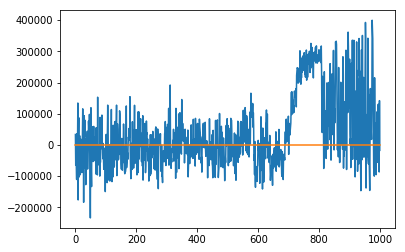

In [8]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    #modelo.epsilon = 0.1
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            #s=time.time()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f}".format(epoca, sum_rewards))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0
            #e=time.time()
            #print(e-s)
            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos_5.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
        print("Somatoria dos rewards: {0:0.2f}".format(sum_rewards_total))
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os v1alores de reward por epoca